In [ ]:
!pip install -q mediapipe==0.10.0

In [ ]:
#Obect detection module
!wget -q -O efficientdet.tflite -q https://storage.googleapis.com/mediapipe-models/object_detector/efficientdet_lite0/int8/1/efficientdet_lite0.tflite
#@title Start downloading here.
!wget -O deeplabv3.tflite -q https://storage.googleapis.com/mediapipe-models/image_segmenter/deeplab_v3/float32/1/deeplab_v3.tflite

In [1]:
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    # Wycięcie fragmentu obrazu
    image_cut = image[bbox.origin_y:bbox.origin_y+bbox.height, bbox.origin_x:bbox.origin_x+bbox.width]
    cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)
    
    # Draw label and score
    
    category = detection.categories[0]
    category_name = category.category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x, MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN, FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)
   
  return image

def cutting(
    image,
    detection_result, padding = 20
) -> np.ndarray:
  """Image cut with using bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be cut.
  Returns:
    Part of image.
  """
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    # Wycięcie fragmentu obrazu
    image_cut = image[bbox.origin_y - padding : bbox.origin_y+bbox.height - padding,
                      bbox.origin_x - padding : bbox.origin_x+bbox.width + padding]
  return image_cut

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


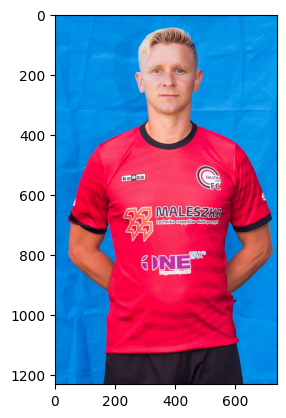

In [2]:
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from matplotlib import pyplot as plt
from PIL import Image

# STEP 2: Create an ObjectDetector object.
base_options = python.BaseOptions(model_asset_path='efficientdet.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options, score_threshold=0.5, max_results=1,running_mode=vision.RunningMode.IMAGE )
detector = vision.ObjectDetector.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file('img/JSK58507.jpg')

# STEP 4: Detect objects in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())

image_cut = cutting(image_copy, detection_result)
#annotated_image = visualize(image_copy, detection_result)
#rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

plt.imshow(image_cut)
plt.show()


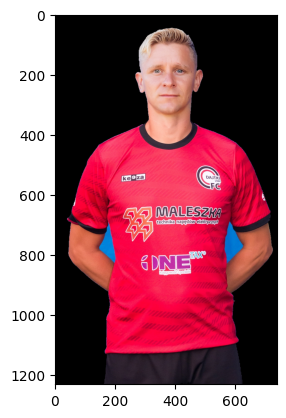

In [3]:
# Konwertuj obraz na przestrzeń kolorów HSV
hsv = cv2.cvtColor(image_cut, cv2.COLOR_BGR2HSV)

# Zdefiniuj zakres koloru niebieskiego
lower_blue = np.array([30,0,0])
upper_blue = np.array([255,255,255])

# Utwórz maskę dla koloru niebieskiego
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Znajdź kontury w masce
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_largest_contour = np.zeros_like(mask)
# Sprawdź, czy znaleziono jakiekolwiek kontury
if contours:
    # Znajdź największy kontur na podstawie powierzchni
    largest_contour = max(contours, key=cv2.contourArea)
    # Utwórz nową maskę o tym samym rozmiarze co oryginalna
    
    # Narysuj największy kontur na nowej masce
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, (255), thickness=cv2.FILLED)

#wygłaź krawędzie w masce
#mask_largest_contour = cv2.blur(mask_largest_contour, (3, 3))
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
opening = cv2.morphologyEx(mask_largest_contour, cv2.MORPH_OPEN, kernel, iterations=3)
mask_largest_contour = cv2.GaussianBlur(mask_largest_contour, (1, 1), 8, 8)

# Zastosuj maskę do obrazu
res = cv2.bitwise_and(image_cut,image_cut, mask= mask_largest_contour)
plt.imshow(res)
plt.show()

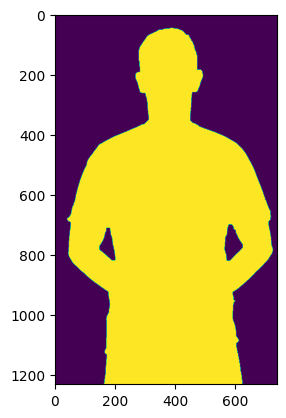

In [21]:
# Konwertuj obraz na przestrzeń kolorów HSV
hsv = cv2.cvtColor(image_cut, cv2.COLOR_BGR2HSV)

# Zdefiniuj zakres koloru niebieskiego
lower_blue = np.array([30,0,0])
upper_blue = np.array([255,255,255])

# Utwórz maskę dla koloru niebieskiego
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Znajdź kontury w masce
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


#Operacja zamknięcia
kernel_size = 3  # Możesz dostosować tę wartość do swoich potrzeb
kernel = np.ones((kernel_size, kernel_size), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=5)
#wygłaź krawędzie w masce
#mask_largest_contour = cv2.blur(mask_largest_contour, (3, 3))
#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (42, 42))
#opening = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=5)
#mask = cv2.GaussianBlur(mask, (3, 3), 8, 8)

# Zastosuj maskę do obrazu
res = cv2.bitwise_and(image_cut,image_cut, mask= mask)
plt.imshow(mask)
plt.show()

In [22]:
import skimage.exposure
# Podzielenie obrazu na kanały
b_channel, g_channel, r_channel = cv2.split(image_cut)

# Dodanie kanału alfa do obrazu
#erozja w celu zmniejszenia maski o kilka px
kernel_size = 3  # Możesz dostosować tę wartość do swoich potrzeb
kernel = np.ones((kernel_size, kernel_size), np.uint8)
# Wykonaj erozję
eroded_mask = cv2.erode(mask, kernel, iterations=1)

# Rozmycie Gaussowskie
blur = cv2.GaussianBlur(eroded_mask, (0,0), sigmaX=1, sigmaY=1, borderType=cv2.BORDER_REPLICATE)

# Przeskalowanie intensywności
result = skimage.exposure.rescale_intensity(blur, in_range=(128,255), out_range=(0,255))

alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * blur
img_BGRA = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
img_RGBA = cv2.cvtColor(img_BGRA, cv2.COLOR_BGRA2RGBA)
cv2.imwrite('output.png', img_RGBA)

True

In [6]:
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from matplotlib import pyplot as plt
from PIL import Image

# STEP 2: Create an ObjectDetector object.
base_options = python.BaseOptions(model_asset_path='efficientdet.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options, score_threshold=0.5, max_results=1,running_mode=vision.RunningMode.IMAGE )
detector = vision.ObjectDetector.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file('img/JSK59245.jpg')

# STEP 4: Detect objects in the input image.
detection_result = detector.detect(image)

#GRABCUT
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

detection = detection_result.detections[0]
# Draw bounding_box
bbox = detection.bounding_box
image_copy = np.copy(image.numpy_view())
mask = np.zeros(image_copy.shape[:2], np.uint8)
# Zdefiniuj prostokąt wokół osoby
rect = (bbox.origin_x,bbox.origin_y,bbox.width,bbox.height)

# Wywołaj funkcję grabCut
cv2.grabCut(image_copy, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Zastosuj maskę
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = image_copy*mask2[:,:,np.newaxis]

plt.imshow(img)
plt.show()

In [ ]:
type(image_cut)

In [ ]:
import mediapipe as mp

BaseOptions = mp.tasks.BaseOptions
FaceDetector = mp.tasks.vision.FaceDetector
FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a face detector instance with the image mode:
options = FaceDetectorOptions(
    base_options=BaseOptions(model_asset_path='blaze_face_short_range.tflite'),
    running_mode=VisionRunningMode.IMAGE)
with FaceDetector.create_from_options(options) as detector:
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB,data=res.astype(np.uint8))
    face_detector_result = detector.detect(mp_image)
    face_img= np.copy(mp_image.numpy_view())
    face_cut = cutting(face_img, face_detector_result)
    plt.imshow(face_cut)
    plt.show()

In [ ]:
face_detector_result

Preview the downloaded image
With the test image downloaded, go ahead and display it.

In [ ]:
import urllib

IMAGE_FILENAMES = ['segmentation_input_rotation0.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-assets/{name}'
  urllib.request.urlretrieve(url, name)

In [ ]:
import cv2
#from google.colab.patches import cv2_imshow
import math
from matplotlib import pyplot as plt

# Height and width that will be used by the model
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

# Performs resizing and showing the image
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))

  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
  plt.imshow(img_rgb)
  plt.show()


Running inference and visualizing the results
To run inference using the image segmentation MediaPipe Task, you will need to initialize the ImageSegmenter using the model. This example will separate the background and foreground of the image and apply separate colors for them to highlight where each distinctive area exists. Image segmentation here will use a category mask, which applies a category to each found item based on confidence

In [ ]:
import numpy as np
import mediapipe as mp
import math

from mediapipe.tasks import python
from mediapipe.tasks.python import vision

name = 'img/JSK58507.jpg'

# Performs resizing and showing the image
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  plt.imshow(img)
  plt.show()

BG_COLOR = (192, 192, 192) # gray
MASK_COLOR = (255, 255, 255) # white


# Create the options that will be used for ImageSegmenter
base_options = python.BaseOptions(model_asset_path='deeplabv3.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

# Create the image segmenter
with vision.ImageSegmenter.create_from_options(options) as segmenter:

  # Loop through demo image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe image file that will be segmented
    image = mp.Image.create_from_file(image_file_name)

    # Retrieve the masks for the segmented image
    segmentation_result = segmenter.segment(image)
    category_mask = segmentation_result.category_mask

    # Generate solid color images for showing the output segmentation mask.
    image_data = image.numpy_view()
    fg_image = np.zeros(image_data.shape, dtype=np.uint8)
    fg_image[:] = MASK_COLOR
    bg_image = np.zeros(image_data.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR

    condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.2
    output_image = np.where(condition, fg_image, bg_image)

    print(f'Segmentation mask of {name}:')
    plt.imshow(image_data)
    #plt.imshow(output_image)
    plt.show()

In [ ]:
import cv2

# Wczytaj obraz
image = cv2.imread('img\JSK58507.jpg')

# Utwórz detektor HOG
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Wykonaj detekcję ciała ludzkiego na obrazie
boxes, weights = hog.detectMultiScale(image, winStride=(4, 4), padding=(8, 8), scale=1.05)

# Narysuj prostokątne ramki wokół wykrytych osób
for (x, y, w, h) in boxes:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
plt.imshow(image)
#plt.imshow(output_image)
plt.show()

In [ ]:
import cv2
print(cv2.getBuildInformation())